In [1]:
# remember to scale problem
# include CoT
# include seeds
# get proper values - length and angles
# plot tau vs speed and Fp vs speed for accuracy


In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('M1_simplified_Aug25.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] +\
           [masses[link] for link in links] +\
           [lengths[link] for link in links] +\
           [inertias[link] for link in links] +\
           [x_body]+[y_body] + [th[link] for link in links if 'foot' not in link]+[r_prismatic[link] for link in links if 'foot' in link]+\
           [dx_body]+[dy_body] + [dth[link] for link in links if 'foot' not in link]+[dr_prismatic[link] for link in links if 'foot' in link] +\
           [ddx_body]+[ddy_body] + [ddth[link] for link in links if 'foot' not in link]+[ddr_prismatic[link] for link in links if 'foot' in link] +\
           [tau['left']] + [tau['right']] +\
           [fp['left']] + [fp['right']] +\
           [grf['x','left']] + [grf['y','left']] +\
           [grf['x','right']] + [grf['y','right']]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body']

for link in links:
    if 'foot' in link:
        DOFs = DOFs + ['{{r_prismatic}}_{{{0}}}'.format(link)]
    else:
        DOFs = DOFs + ['theta_{0}'.format(link)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body':5670/1000,
           'UL': 867/1000,
           'UR': 867/1000,
           'footL': 180/1000,
           'footR': 180/1000}

lengths_ = {'body': 24/100,
           'UL': 15.0/100,
           'UR': 15.0/100,
           'footL': 4.0/100,
           'footR': 4.0/100}

''' ****** '''
inertias_ = {'body': (masses_['body']*lengths_['body']**2)/12, # body rotate about its center 
            'UL': (masses_['UL']*lengths_['UL']**2)/12, # rotates as pendulumn ?
            'UR': (masses_['UR']*lengths_['UR']**2)/12,
            'footL': 0.0,
            'footR': 0.0}

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
links = ['body','UL','UR','footL','footR']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
feet = ['footL','footR']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}


total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

def get_var_list_zeros(m,n):
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    prismatic_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
        
    for side in sides:
                
        tau_value.update({(side): \
        BW*(m.tau_torque[n,side])})
    
        prismatic_force_value.update({(side):\
        BW*(m.Fp[n,side])})
        
    for foot in feet:
        GRF_X_value.update({(foot):BW*(m.GRF_x[n,'+ve',foot]-m.GRF_x[n,'-ve',foot])})
        GRF_Y_value.update({(foot):BW*(m.GRF_y[n,foot])})
    
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left']] + [tau_value['right']] +\
               [prismatic_force_value['left']] + [prismatic_force_value['right']] +\
               [GRF_X_value['footL']] + [GRF_Y_value['footL']] +\
               [GRF_X_value['footR']] + [GRF_Y_value['footR']]
    return var_list



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


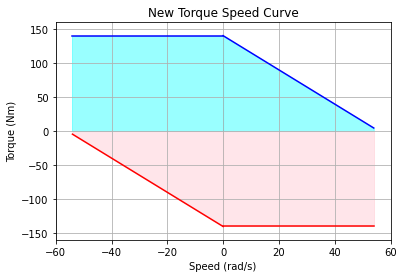

In [3]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

max_torque_p = []
max_torque_n = []

for ii in range(len(x_p)):
    max_torque_p.append(stall_torque)
    max_torque_n.append(-stall_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, max_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, max_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, max_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, max_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>

<a id='time_step'></a>

In [4]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run",9:"Stop_Periodic_Run",10:"Start_Periodic_Run"}

test = tests[9]
V_avg = 5.0
if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.3
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Run":
    N = 50
    TT = 0.3 # 2Hz but only half a gait due to symmetry
    V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
    x_final = 3.0 # for display
elif test == "Stop_Periodic_Run" or test == "Start_Periodic_Run":
    import csv
    file = open(str(round(V_avg))+'.csv')
    csvreader = csv.reader(file)
    rows = []
    for row in csvreader:
        rows.append(row)
    initial_conditions = {}
    for item in rows:
        initial_conditions[item[0]] = float(item[1])
    x_final = 5.0 # for display 
    if test == "Stop_Periodic_Run":
        N = 50
        TT = 0.8 # 2Hz but only half a gait due to symmetry
    elif test == "Start_Periodic_Run":
        N = 50
        TT = 1.0
    else: pass   
    
else:
    N = 50
    TT = 0.5
    

In [5]:
print("total mass = " ,total_mass)
print("test = ",test)

total mass =  7.763999999999999
test =  Stop_Periodic_Run


In [6]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.links = Set(initialize = links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)
m.feet = Set(initialize = feet)


#Params--------------------------
m.g = Param(initialize = 9.81)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.links, initialize = masses_)
m.lengths = Param(m.links, initialize = lengths_)
m.inertias = Param(m.links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [7]:
''' CONSTRAINTS  - Integration'''

# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [8]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.feet)
for n in range(1,N+1):
    m.foot_position[n,'Y','footL'].setlb(0.0)
    m.foot_position[n,'Y','footR'].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,foot): sym.lambdify(sym_list,r_links[foot][coordinates[wdof]],modules = [func_map])}) for foot in feet for wdof in WDOFs]

def def_foot_position(m,n,wdof,foot):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,foot] == lamb_foot_position[wdof,foot](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_position)

m.mu = Param(initialize = 10.0,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.feet, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.feet, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.feet, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.feet, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.feet, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(foot): sym.lambdify(sym_list,(r_links[foot].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for foot in feet]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,foot):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',foot]-m.foot_velocity[n,'X','-ve',foot] == lamb_foot_velocity_x[foot](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_velocity)

def def_friction_cone(m,n,foot):
    return m.friction_cone[n,foot] == m.mu*m.GRF_y[n,foot] - (m.GRF_x[n,'+ve',foot] + m.GRF_x[n,'-ve',foot])
m.friction_cone_constraint = Constraint(m.N, m.feet, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,foot):
    if n < N:
        return m.foot_position[n+1,'Y',foot]*m.GRF_y[n,foot] <= m.ground_penalty[n,'contact',foot]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.feet, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,foot):
    return (m.foot_velocity[n,'X','+ve',foot]+m.foot_velocity[n,'X','-ve',foot])*m.friction_cone[n,foot] <= m.ground_penalty[n,'friction',foot]
m.ground_friction_constraint = Constraint(m.N, m.feet, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,foot):
    return m.foot_velocity[n,'X','+ve',foot]*m.GRF_x[n,'+ve',foot] <= m.ground_penalty[n,'slip_+ve',foot]
m.ground_slip_positive_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,foot):
    return m.foot_velocity[n,'X','-ve',foot]*m.GRF_x[n,'-ve',foot] <= m.ground_penalty[n,'slip_-ve',foot]
m.ground_slip_negative_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_negative)

# bound contact forces at last node
for foot in feet:
    m.GRF_y[N,foot].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,foot].fix(0.0)

In [9]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides,bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides,bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side): sym.lambdify(sym_list,dr_links[motor_w_angle[side]][2],modules = [func_map])}) for side in sides]

def def_angular_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side] == lamb_tau_velocity[side](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides,rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side):
    return m.tau_torque[n,side] <= m.tau_velocity[n,side]*m_grad + stall_torque
m.constant_power_right_constraint = Constraint(m.N, m.sides,rule = def_constant_power_right)

def def_constant_power_left(m,n,side):
    return m.tau_torque[n,side] >= m.tau_velocity[n,side]*m_grad - stall_torque
m.constant_power_left_constraint = Constraint(m.N, m.sides,rule = def_constant_power_left)

In [10]:
# m.Fp = Var(m.N, m.sides, bounds = (-total_mass*9.81,total_mass*9.81))

# Fo = 5*(total_mass*9.81) = 383N

# given the torque speed curve, what radius should the pinion be such that Fo = 383N?
# using the equation: y_p = -2.8*x_p + 153.4
pinion_radius = 0.37 # T = F*d
Fo = stall_torque/pinion_radius # stall force
# max_power = max_torque*max_rotational_speed # Tau_max*w_max    https://www.clear.rice.edu/elec201/Book/motors.html 
max_power = (stall_torque*no_load_speed)/4
Fp_max = max_torque/pinion_radius
m.Fp = Var(m.N, m.sides,bounds = (-Fp_max,Fp_max))

max_translational_speed = no_load_speed*pinion_radius 
m.Fp_velocity = Var(m.N, m.sides,bounds = (-max_translational_speed,max_translational_speed))

lamb_Fp_velocity = {}
lamb_Fp_velocity.update({('left'): sym.lambdify(sym_list,dq[5],modules = [func_map])})
lamb_Fp_velocity.update({('right'): sym.lambdify(sym_list,dq[6],modules = [func_map])})

def def_Fp_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.Fp_velocity[n,side] == lamb_Fp_velocity[side](*var_list)   
m.Fp_velocity_constraint = Constraint(m.N, m.sides, rule = def_Fp_velocity)

# assume straight line
def def_Fp_right(m,n,side):
    return m.Fp[n,side] <= Fo*(1-((Fo/(4*max_power))*m.Fp_velocity[n,side]))
m.Fp_right_constraint = Constraint(m.N, m.sides,rule = def_Fp_right)

def def_Fp_left(m,n,side):
    return m.Fp[n,side] >= Fo*(-1-((Fo/(4*max_power))*m.Fp_velocity[n,side]))
m.Fp_left_constraint = Constraint(m.N, m.sides,rule = def_Fp_left)

<a id='constraints'></a>

In [11]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_links['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            elif dof_i == '{r_prismatic}_{footL}':
                return m.q[1,'{r_prismatic}_{footL}'] == m.q[N,'{r_prismatic}_{footR}']
            elif dof_i == '{r_prismatic}_{footR}':
                return m.q[1,'{r_prismatic}_{footR}'] == m.q[N,'{r_prismatic}_{footL}']
            elif dof_i == 'theta_UL':
                return m.q[1,'theta_UL'] == m.q[N,'theta_UR']
            elif dof_i == 'theta_UR':
                return m.q[1,'theta_UR'] == m.q[N,'theta_UL']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [12]:
''' Use this code for tests '''

# BOUND VALUES
for n in range(1,N+1):
    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
    
    # 0.15 - 0.5 = 0.35
    
    m.q[n,'{r_prismatic}_{footL}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footL}'].setub(0.35)
    m.q[n,'{r_prismatic}_{footR}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footR}'].setub(0.35)
    
    m.q[n,'theta_UL'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UL'].setub(np.pi*(1/3))
    m.q[n,'theta_UR'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UR'].setub(np.pi*(1/3))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)
    
    else:
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
        
        if test == "Drop_Hop_Test" or "Periodic_Hop":
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]
            
        else:
            [m.tau_torque[n,side].fix(0.0) for side in sides]
            [m.Fp[n,side].fix(0.0) for side in sides]
    else:
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run":
            pass
        else:
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]

<a id='initial_conditions'></a>

In [13]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.3)
    m.q[1,'y_body'].fix(1.3)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
    m.q[1,'theta_UL'].fix(np.pi*(-2/9))
    m.q[1,'theta_UR'].fix(np.pi*(2/9))
        
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(-1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[1, 'Y', 'footL'].fix(0.2)
    m.foot_position[1, 'Y', 'footR'].fix(0.2)
    
#     m.q[N,'x_body'].setub(0.7)
#     m.q[N,'x_body'].setlb(0.3)

        
# elif test == "Hop_Test":
#     #  ----------------------------- HOP TEST ---------------------------

#     # initial condition
#     m.q[1,'y_body'].fix(0.35)
#     m.q[1,'x_body'].fix(0.0)
#     m.q[1,'theta_body'].fix(np.pi*(0.0))
#     m.foot_position[1, 'Y', 'A'].fix(0.0)
#     m.foot_position[1, 'Y', 'B'].fix(0.0)
#     m.foot_position[1, 'X', 'A'].fix(-0.2)
#     m.foot_position[1, 'X', 'B'].fix(0.2)
        
#     m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(-1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[round(N/5), 'Y', 'footL'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'footR'].setub(0.05)
    
    m.q[N,'theta_UL'].setub(np.pi*(1/6))
    m.q[N,'theta_UR'].setlb(np.pi*(1/6))
    
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)   
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
     
    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'footL'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footL'].value = m.mu.value*m.GRF_y[n,'footL'].value
        m.GRF_y[n,'footR'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footR'].value = m.mu.value*m.GRF_y[n,'footR'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.0))
    m.q[1,'theta_UR'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    m.dq[N,'theta_UL'].fix(0.0)
    m.dq[N,'theta_UR'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)
    m.q[N,'theta_UL'].fix(np.pi*(0.0))
    m.q[N,'theta_UR'].fix(np.pi*(0.0))

    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.5))
    m.q[1,'theta_UR'].fix(np.pi*(0.5))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    

elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].setlb(np.pi*(-1/6))
    m.q[1,'theta_UL'].setub(np.pi*(-1/12))
    
    m.q[1,'theta_UR'].setub(np.pi*(1/6))
    m.q[1,'theta_UR'].setlb(np.pi*(1/12))
    
    for n in range(1,N+1):
        m.GRF_y[n,'footL'].fix(0.0)
        m.foot_position[n, 'Y', 'footL'].setlb(0.05)
    
    m.GRF_y[1,'footR'].fix(0.0)
    
    
    
    
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)


elif test == "Stop_Periodic_Run":
    
#     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
    
    m.q[1,'x_body'].fix(initial_conditions['x_body']) # initial condition
    m.q[1,'y_body'].fix(initial_conditions['y_body'])
    m.q[1,'theta_body'].fix(initial_conditions['theta_body'])
    m.q[1,'theta_UL'].fix(initial_conditions['theta_UL'])
    m.q[1,'theta_UR'].fix(initial_conditions['theta_UR'])
    m.q[1,'{r_prismatic}_{footL}'].fix(initial_conditions['r_left'])
    m.q[1,'{r_prismatic}_{footR}'].fix(initial_conditions['r_right'])  
    m.GRF_y[1,'footL'].fix(0.0)
    m.GRF_y[1,'footR'].fix(0.0)
    
    m.dq[1,'x_body'].fix(initial_conditions['dx_body']) # initial condition
    m.dq[1,'y_body'].fix(initial_conditions['dy_body'])
    m.dq[1,'theta_body'].fix(initial_conditions['dtheta_body'])
    m.dq[1,'theta_UL'].fix(initial_conditions['dtheta_UL'])
    m.dq[1,'theta_UR'].fix(initial_conditions['dtheta_UR'])
    m.dq[1,'{r_prismatic}_{footL}'].fix(initial_conditions['dr_left'])
    m.dq[1,'{r_prismatic}_{footR}'].fix(initial_conditions['dr_right'])  
    
    for n5 in range(N-5,N+1): # last 5 nodes 
        for dof_i in DOFs:
            if dof_i == 'x_body' or dof_i == 'theta_body':
                m.dq[n5,dof_i].setub(0.0)
            else:
                m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
        m.foot_position[n5, 'Y', 'footL'].fix(0.0)
        m.foot_position[n5, 'Y', 'footR'].fix(0.0)
    
elif test == "Start_Periodic_Run":
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]

    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.0))
    m.q[1,'theta_UR'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.35/2)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.35/2)  
        
    # initial condition
    m.q[N,'y_body'].fix(initial_conditions['y_body'])
    m.q[N,'theta_body'].fix(initial_conditions['theta_body'])
    m.q[N,'theta_UL'].fix(initial_conditions['theta_UL'])
    m.q[N,'theta_UR'].fix(initial_conditions['theta_UR'])
    m.q[N,'{r_prismatic}_{footL}'].fix(initial_conditions['r_left'])
    m.q[N,'{r_prismatic}_{footR}'].fix(initial_conditions['r_right'])  
    
    m.dq[N,'x_body'].fix(initial_conditions['dx_body']) # initial condition
#     m.dq[N,'y_body'].fix(initial_conditions['dy_body'])
#     m.dq[N,'theta_body'].fix(initial_conditions['dtheta_body'])
#     m.dq[N,'theta_UL'].fix(initial_conditions['dtheta_UL'])
#     m.dq[N,'theta_UR'].fix(initial_conditions['dtheta_UR'])
#     m.dq[N,'{r_prismatic}_{footL}'].fix(initial_conditions['dr_left'])
#     m.dq[N,'{r_prismatic}_{footR}'].fix(initial_conditions['dr_right'])  
    

else: pass

<a id='cost_function'></a>

In [14]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    
    for n in range(1,N+1):
            for side in sides:
                actuation_sum += (m.tau_torque[n,side])**2 + (m.Fp[n,side])**2
                
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side])**2 + (m.Fp[n,side])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for foot in feet:
                    pen_sum += m.ground_penalty[n,gc,foot] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum
    elif test == "Stop_Periodic_Run":
        return row*pen_sum + m.q[N,'x_body']
    elif test == "Start_Periodic_Run":
        return row*pen_sum #+ T
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [15]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_UL(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UL'](*var_list) == 0
m.EOM_th_UL_constraint = Constraint(m.N, rule = EOM_th_UL)

def EOM_th_UR(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UR'](*var_list) == 0
m.EOM_th_UR_constraint = Constraint(m.N, rule = EOM_th_UR)

def EOM_r_prismatic_footL(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footL}'](*var_list) == 0
m.EOM_r_prismatic_footL_constraint = Constraint(m.N, rule = EOM_r_prismatic_footL)

def EOM_r_prismatic_footR(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footR}'](*var_list) == 0
m.EOM_r_prismatic_footR_constraint = Constraint(m.N, rule = EOM_r_prismatic_footR)

In [16]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*10   # maximum number of iterations
opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=300000
max_cpu_time=6000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    10936
Number of nonzeros in inequality constraint Jacobian.:     2050
Number of nonzeros in Lagrangian Hessian.............:     5068

Total number of variables............................:     2661
                     variables with only lower bounds:      388
                variables with lower and upper bounds:     1382
                     variables with only u

  95r 3.8067775e+06 1.36e+01 1.06e+04  -0.8 6.99e+02    -  5.20e-01 5.45e-02f  1
  96r 3.8063835e+06 1.36e+01 1.06e+04  -0.8 4.19e+02    -  6.99e-03 5.07e-03f  1
  97r 3.8080365e+06 1.35e+01 2.65e+03  -0.8 1.14e+00   0.8 6.69e-01 3.15e-01f  1
  98r 3.8089512e+06 1.35e+01 3.09e+03  -0.8 4.21e+02    -  6.76e-02 3.63e-03f  1
  99r 3.7910776e+06 1.06e+01 1.39e+03  -0.8 4.12e+02    -  1.53e-01 3.02e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 3.7960299e+06 1.05e+01 3.17e+02  -0.8 2.37e+00   0.3 7.75e-01 7.86e-01f  1
 101r 3.7969015e+06 1.05e+01 4.71e+00  -0.8 8.87e-01   0.7 1.00e+00 1.00e+00f  1
 102r 3.6554671e+06 1.04e+01 9.09e+01  -1.5 2.64e+00   0.2 2.18e-01 3.83e-01f  1
 103r 3.6403708e+06 1.01e+01 4.53e+02  -1.5 2.12e+01  -0.2 2.05e-02 8.06e-02f  1
 104r 3.6357608e+06 1.01e+01 3.74e+02  -1.5 8.02e+01   0.2 8.40e-04 1.89e-02f  1
 105r 3.6355033e+06 1.01e+01 2.57e+03  -1.5 3.01e+00   0.6 4.92e-01 4.16e-03f  1
 106r 3.6179673e+06 8.66e+00

 232r 2.5606141e+06 4.46e+00 5.37e+02  -3.5 3.21e+02  -1.7 3.32e-03 4.88e-03f  1
 233r 2.5639432e+06 4.44e+00 6.96e+02  -3.5 1.69e+02  -1.2 2.12e-02 7.72e-03f  1
 234r 2.5832886e+06 4.41e+00 6.59e+02  -3.5 3.40e+02  -1.7 9.94e-04 6.60e-03f  1
 235r 2.5854525e+06 4.40e+00 7.88e+02  -3.5 1.83e+02  -1.3 1.88e-02 5.10e-03f  1
 236r 2.6117334e+06 4.35e+00 7.73e+02  -3.5 3.59e+02  -1.8 7.97e-03 9.41e-03f  1
 237r 2.6137262e+06 4.33e+00 9.42e+02  -3.5 1.98e+02  -1.3 2.60e-02 6.95e-03f  1
 238r 2.6157231e+06 4.26e+00 5.33e+02  -3.5 9.06e+01  -0.9 9.17e-03 4.55e-02f  1
 239r 2.6152657e+06 4.25e+00 4.75e+02  -3.5 3.68e+01  -0.5 4.93e-03 1.90e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 2.6145958e+06 4.25e+00 4.72e+02  -3.5 1.43e+01  -0.1 2.84e-03 1.82e-02f  1
 241r 2.6144585e+06 4.25e+00 4.73e+02  -3.5 3.65e+02  -0.5 2.63e-04 1.22e-04f  1
 242r 2.6083796e+06 4.22e+00 1.36e+03  -3.5 1.60e+01  -0.1 2.77e-02 1.38e-01f  1
 243r 2.6073850e+06 4.21e+00

 370r 3.3982410e+06 1.61e+00 5.83e+02  -3.5 3.63e+01  -0.7 4.34e-01 9.33e-02f  1
 371r 3.3982651e+06 1.61e+00 6.45e+02  -3.5 1.42e+01  -0.2 1.43e-01 5.03e-04f  1
 372r 3.4081642e+06 1.62e+00 6.24e+02  -3.5 4.01e+01  -0.7 5.10e-03 7.75e-02f  1
 373r 3.4164148e+06 1.61e+00 6.14e+02  -3.5 1.01e+02  -1.2 8.23e-02 2.52e-02f  1
 374r 3.4256413e+06 1.61e+00 6.06e+02  -3.5 2.07e+02  -1.7 1.32e-02 1.31e-02f  1
 375r 3.4302941e+06 1.60e+00 6.02e+02  -3.5 3.18e+02  -2.2 7.23e-03 7.43e-03f  1
 376r 3.4303253e+06 1.60e+00 6.07e+02  -3.5 4.84e+01  -0.8 3.35e-02 2.04e-04f  1
 377r 3.4382281e+06 1.60e+00 5.95e+02  -3.5 1.19e+02  -1.3 4.50e-02 2.03e-02f  1
 378r 3.4392740e+06 1.60e+00 5.21e+02  -3.5 5.34e+01  -0.9 1.12e-01 6.53e-03f  1
 379r 3.4624158e+06 1.60e+00 5.11e+02  -3.5 1.28e+02  -1.4 1.71e-04 5.45e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 3.4639479e+06 1.60e+00 5.03e+02  -3.5 2.37e+02  -1.8 5.15e-02 1.48e-03f  1
 381r 3.4651857e+06 1.60e+00

 509r 5.0180550e+06 1.06e+00 1.72e+02  -3.5 1.98e+01  -1.4 4.42e-05 2.66e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510r 5.0180626e+06 1.06e+00 3.35e+02  -3.5 3.08e+01  -1.0 5.98e-02 9.35e-05f  1
 511r 5.0183402e+06 1.06e+00 1.31e+03  -3.5 2.97e+00  -0.6 5.42e-01 1.40e-02f  1
 512r 5.0204044e+06 1.04e+00 1.20e+03  -3.5 1.08e+02  -1.0 3.35e-05 9.33e-03f  1
 513r 5.0204146e+06 1.04e+00 1.20e+03  -3.5 2.38e+01  -1.5 3.01e-01 1.43e-04f  1
 514r 5.0042921e+06 9.71e-01 1.12e+03  -3.5 6.01e+01  -2.0 1.62e-04 7.07e-02f  1
 515r 5.0038743e+06 9.50e-01 1.06e+03  -3.5 1.82e+01  -1.6 7.95e-02 4.80e-02f  1
 516r 5.0044355e+06 9.46e-01 9.28e+02  -3.5 9.99e-01  -0.2 1.00e+00 1.25e-01f  1
 517r 5.0054691e+06 9.40e-01 8.67e+02  -3.5 2.79e+00  -0.7 1.19e-01 6.65e-02f  1
 518r 5.0085068e+06 9.25e-01 5.00e+02  -3.5 9.25e-01  -0.3 7.67e-01 4.23e-01f  1
 519r 5.0168310e+06 8.77e-01 3.46e+02  -3.5 3.03e+00  -0.8 1.03e-01 3.98e-01f  1
iter    objective    inf_pr 

 604  9.3107269e+05 3.09e-01 1.60e+04  -1.0 7.46e+03    -  3.01e-03 7.73e-04h  5
 605  9.3147919e+05 3.09e-01 1.68e+04  -1.0 7.86e+03    -  1.83e-02 7.13e-04h  5
 606  9.3280322e+05 3.08e-01 1.72e+04  -1.0 2.76e+03    -  1.48e-02 2.88e-03h  4
 607  9.3454117e+05 3.07e-01 1.93e+04  -1.0 2.45e+03    -  5.77e-02 4.16e-03h  4
 608  9.3610302e+05 3.06e-01 2.04e+04  -1.0 4.71e+03    -  3.25e-02 4.12e-03h  5
 609  9.6256402e+05 6.47e+00 1.76e+04  -1.0 6.41e+03    -  4.29e-02 7.34e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  9.8550015e+05 6.23e+00 1.54e+04  -1.0 2.97e+02  -2.5 4.74e-04 3.66e-02w  1
 611  9.9559019e+05 6.12e+00 1.44e+04  -1.0 1.17e+03  -3.0 1.28e-03 1.65e-02w  1
 612  9.3692993e+05 3.05e-01 2.20e+04  -1.0 2.14e+04  -3.4 4.29e-02 2.29e-03h  5
 613  9.3795718e+05 3.04e-01 2.19e+04  -1.0 5.08e+03    -  4.21e-04 2.59e-03h  6
 614  9.3861843e+05 3.04e-01 2.32e+04  -1.0 1.16e+03  -3.0 3.24e-02 1.01e-03h  1
 615  9.3954652e+05 3.03e-01

 697  6.8327109e+05 5.15e+00 8.22e+03  -1.0 7.46e+02  -0.0 6.39e-04 2.48e-03h  1
 698  6.8492613e+05 5.14e+00 9.43e+03  -1.0 6.57e+02   0.4 3.38e-04 5.57e-04h  1
 699  6.8786452e+05 5.14e+00 8.87e+03  -1.0 6.69e+02  -0.1 1.31e-03 1.04e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  6.9024671e+05 5.14e+00 8.60e+03  -1.0 6.41e+02   0.3 1.70e-03 7.17e-04h  3
 701  6.9054256e+05 5.13e+00 1.09e+04  -1.0 6.28e+02   0.8 4.73e-04 7.87e-05h  5
 702r 6.9054256e+05 5.13e+00 1.00e+03   0.7 0.00e+00   0.3 0.00e+00 4.34e-07R 12
 703r 6.9454715e+05 1.27e+00 3.49e+03   0.7 5.11e+03    -  2.39e-03 9.96e-04f  1
 704  6.9342669e+05 1.27e+00 1.00e+02  -1.0 1.23e+04    -  1.95e-03 1.06e-03f  1
 705  6.9002456e+05 1.27e+00 9.97e+01  -1.0 9.02e+03    -  4.21e-03 3.40e-03f  1
 706  6.8580852e+05 1.29e+00 1.18e+02  -1.0 9.65e+03    -  6.65e-03 5.71e-03f  1
 707  6.7774957e+05 1.44e+00 3.74e+03  -1.0 9.52e+03    -  4.97e-02 1.37e-02f  1
 708  6.7307356e+05 1.51e+00

 791  7.2693756e+05 1.23e+00 4.07e+04  -1.0 2.24e+02  -0.6 1.71e-02 8.38e-03h  1
 792  7.2697335e+05 1.23e+00 1.98e+04  -1.0 2.23e+02  -0.2 4.26e-03 1.60e-04h  1
 793  7.2808705e+05 1.22e+00 1.08e+04  -1.0 2.49e+02  -0.7 4.54e-03 6.00e-03h  1
 794  7.2837473e+05 1.22e+00 1.20e+04  -1.0 2.11e+02  -0.2 5.45e-04 4.37e-04h  1
 795  7.3945174e+05 1.21e+00 2.26e+04  -1.0 2.28e+02  -0.7 8.24e-04 1.30e-02h  1
 796  7.4012003e+05 1.21e+00 1.60e+04  -1.0 1.63e+02  -0.3 1.22e-02 5.17e-04h  1
 797  7.6820590e+05 1.19e+00 1.01e+04  -1.0 3.04e+02  -0.8 1.29e-02 1.88e-02h  1
 798  7.7848907e+05 1.18e+00 1.18e+04  -1.0 1.65e+02  -0.3 2.01e-04 7.83e-03h  1
 799  7.8497392e+05 1.17e+00 8.67e+03  -1.0 1.51e+02   0.1 9.03e-03 4.42e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  8.1465885e+05 1.15e+00 9.37e+03  -1.0 1.64e+02  -0.4 6.38e-03 2.08e-02h  1
 801  8.5253673e+05 1.12e+00 5.94e+04  -1.0 1.51e+02   0.0 6.79e-03 2.63e-02h  1
 802  8.6824354e+05 1.11e+00

 884  4.2407922e+06 6.84e-01 5.42e+05  -1.0 1.03e+02   1.1 1.75e-02 2.63e-02h  1
 885  4.2465379e+06 6.84e-01 5.43e+05  -1.0 6.06e+01   1.5 3.85e-03 4.66e-04h  1
 886  4.2534801e+06 6.83e-01 5.78e+05  -1.0 9.45e+01   1.0 3.13e-03 7.29e-04h  1
 887  4.3013155e+06 6.80e-01 5.70e+05  -1.0 6.03e+01   1.5 4.35e-04 3.89e-03h  1
 888  4.3361614e+06 6.77e-01 5.21e+05  -1.0 1.25e+02   1.0 2.21e-03 4.35e-03h  1
 889  4.3482131e+06 6.77e-01 5.63e+05  -1.0 6.56e+01   1.4 9.91e-03 1.02e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890  4.3570766e+06 6.76e-01 7.53e+05  -1.0 1.37e+02   0.9 8.98e-03 1.30e-03h  1
 891  4.3711548e+06 6.75e-01 7.72e+05  -1.0 4.75e+01   1.4 6.39e-03 1.12e-03h  1
 892  4.3822097e+06 6.74e-01 8.72e+05  -1.0 4.90e+01   0.9 8.22e-03 1.16e-03h  1
 893  4.6024614e+06 6.62e-01 7.79e+05  -1.0 4.77e+01   1.3 2.06e-04 1.76e-02h  1
 894  4.7483213e+06 6.51e-01 5.56e+05  -1.0 5.80e+01   0.8 7.50e-03 1.78e-02h  1
 895  4.7897269e+06 6.48e-01

 978  1.1646539e+07 2.34e-01 3.55e+06  -1.0 3.30e+01   2.3 1.66e-02 9.85e-03h  1
 979  1.1738348e+07 2.28e-01 3.25e+06  -1.0 3.32e+01   1.8 9.76e-03 2.63e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980  1.1768523e+07 2.26e-01 4.83e+06  -1.0 3.22e+01   2.2 3.25e-02 7.35e-03h  1
 981  1.1831828e+07 2.21e-01 4.61e+06  -1.0 3.29e+01   1.8 7.68e-04 2.01e-02h  1
 982  1.1884375e+07 2.18e-01 4.78e+06  -1.0 3.21e+01   2.2 1.77e-02 1.33e-02h  1
 983  1.1973756e+07 2.11e-01 4.62e+06  -1.0 3.38e+01   1.7 2.94e-02 3.32e-02h  1
 984  1.1976631e+07 2.11e-01 5.75e+06  -1.0 3.08e+01   2.1 2.89e-02 8.17e-04h  1
 985  1.2109461e+07 1.98e-01 5.01e+06  -1.0 3.74e+01   1.7 1.65e-01 6.14e-02h  1
 986  1.2144201e+07 1.96e-01 5.41e+06  -1.0 2.90e+01   2.1 2.74e-02 1.16e-02h  1
 987  1.2213830e+07 1.86e-01 5.02e+06  -1.0 3.75e+01   1.6 6.44e-02 4.86e-02h  1
 988  1.2334161e+07 1.78e-01 4.15e+06  -1.0 2.71e+01   2.0 1.28e-02 4.61e-02h  1
 989  1.2351159e+07 1.74e-01

1072  7.2972960e+06 5.31e-03 3.42e+05  -1.0 1.60e+01   0.8 3.92e-03 8.02e-03f  1
1073  7.2416986e+06 5.14e-03 3.30e+05  -1.0 5.71e+00   1.2 2.79e-02 3.32e-02f  1
1074  7.1395807e+06 5.04e-03 3.24e+05  -1.0 1.82e+01   0.7 2.27e-02 1.96e-02f  1
1075  7.1096248e+06 4.96e-03 3.21e+05  -1.0 6.23e+00   1.2 2.95e-02 1.66e-02f  1
1076  6.9958144e+06 4.86e-03 3.13e+05  -1.0 2.07e+01   0.7 1.17e-02 2.01e-02f  1
1077  6.9556969e+06 4.76e-03 3.12e+05  -1.0 6.91e+00   1.1 5.83e-02 2.03e-02f  1
1078  6.8427381e+06 4.68e-03 3.05e+05  -1.0 2.32e+01   0.6 5.05e-03 1.86e-02f  1
1079  6.8088079e+06 4.60e-03 3.03e+05  -1.0 7.65e+00   1.1 3.33e-02 1.61e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  6.7113372e+06 4.54e-03 2.98e+05  -1.0 2.58e+01   0.6 1.82e-02 1.51e-02f  1
1081  6.6408743e+06 4.40e-03 3.46e+05  -1.0 8.52e+00   1.0 8.13e-02 3.08e-02f  1
1082  6.5120934e+06 4.32e-03 3.20e+05  -1.0 2.92e+01   0.5 9.18e-03 1.86e-02f  1
1083  6.4679573e+06 4.24e-03

1165  1.6815582e+06 1.31e-03 4.13e+05  -1.0 8.16e-01   1.6 8.56e-01 9.64e-02f  1
1166  1.6679014e+06 1.70e-03 3.60e+05  -1.0 2.42e+00   1.1 4.13e-01 1.52e-01f  1
1167  1.6235599e+06 8.65e-03 3.15e+05  -1.0 7.28e+00   0.6 3.88e-01 1.75e-01f  1
1168  1.5982384e+06 8.39e-03 3.15e+05  -1.0 4.03e+01   0.1 1.19e-01 3.59e-02f  1
1169  1.5477816e+06 6.15e-03 2.36e+05  -1.0 8.76e+00   0.6 1.43e-01 2.13e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170  1.5468857e+06 6.06e-03 2.35e+05  -1.0 3.16e+00   1.0 2.68e-02 1.10e-02f  1
1171  1.5402916e+06 4.05e-03 2.36e+05  -1.0 1.20e+00   1.4 7.70e-01 2.44e-01f  1
1172  1.4662905e+06 1.03e-02 1.56e+04  -1.0 3.58e+00   0.9 5.49e-01 9.21e-01f  1
1173  1.4537378e+06 9.98e-03 2.77e+04  -1.0 1.04e+01   0.5 4.56e-01 5.66e-02f  1
1174  1.4398190e+06 1.00e-02 2.81e+04  -1.0 2.74e+01  -0.0 6.79e-02 2.64e-02f  1
1175  1.2946526e+06 6.28e-02 6.21e+03  -1.0 7.26e+00   0.4 4.63e-01 7.46e-01f  1
1176  1.2931624e+06 6.27e-02

1258  9.3449993e+05 2.45e-06 2.20e+00  -3.8 7.82e-02   1.4 1.00e+00 1.00e+00f  1
1259  9.3335571e+05 2.21e-05 2.20e+00  -3.8 2.35e-01   1.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260  9.3030180e+05 1.60e-04 1.34e+02  -3.8 7.04e-01   0.5 1.00e+00 8.91e-01f  1
1261  9.2356703e+05 8.23e-04 7.34e+02  -3.8 2.11e+00   0.0 1.00e+00 6.57e-01f  1
1262  9.2348210e+05 8.21e-04 5.76e+03  -3.8 6.25e+00  -0.5 3.48e-01 2.82e-03f  1
1263  9.2294550e+05 8.21e-04 5.66e+03  -3.8 1.83e+01  -0.9 9.05e-04 6.59e-03f  1
1264  9.2249023e+05 8.13e-04 4.03e+04  -3.8 6.80e+00  -0.5 4.28e-01 1.50e-02f  1
1265  9.1668720e+05 1.47e-03 4.72e+04  -3.8 2.04e+01  -1.0 2.28e-01 6.45e-02f  1
1266  9.1666735e+05 1.46e-03 4.45e+04  -3.8 9.51e-01   0.3 4.88e-01 4.88e-03f  1
1267  9.1561943e+05 1.36e-03 4.35e+04  -3.8 2.86e+00  -0.1 3.78e-01 8.63e-02f  1
1268  9.1384465e+05 1.37e-03 4.06e+04  -3.8 8.54e+00  -0.6 8.98e-02 4.96e-02f  1
1269  9.1346193e+05 1.06e-03

1353  6.8677558e+05 1.00e-03 5.64e+02  -3.8 4.29e+01  -1.4 7.81e-02 1.02e-02f  1
1354  6.8314693e+05 1.23e-03 5.75e+02  -3.8 1.45e+02  -1.9 1.94e-02 1.57e-02f  1
1355  6.8295690e+05 1.23e-03 2.60e+03  -3.8 4.93e+01  -1.5 1.00e-01 2.30e-03f  1
1356  6.7792212e+05 2.17e-03 2.52e+03  -3.8 1.70e+02  -2.0 1.72e-02 1.88e-02f  1
1357  6.7349564e+05 2.41e-03 8.19e+02  -3.8 5.74e+01  -1.5 1.61e-03 4.80e-02f  1
1358  6.7349531e+05 2.41e-03 2.65e+03  -3.8 7.23e+00  -0.2 1.04e-01 6.12e-05f  1
1359  6.7348855e+05 2.41e-03 1.69e+04  -3.8 4.02e+00  -0.7 3.83e-01 6.70e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360  6.6729442e+05 3.00e-03 1.29e+04  -3.8 1.17e+01  -1.2 1.88e-01 2.09e-01f  1
1361  6.6708922e+05 3.00e-03 1.29e+04  -3.8 3.48e+01  -1.6 7.04e-03 2.36e-03f  1
1362  6.5851804e+05 4.20e-03 4.69e+03  -3.8 1.33e+01  -1.2 2.49e-02 2.62e-01f  1
1363  6.5527911e+05 4.37e-03 4.76e+03  -3.8 4.05e+01  -1.7 5.87e-02 3.31e-02f  1
1364  6.5246822e+05 4.26e-03

1446  4.9342426e+05 7.37e-04 7.28e+01  -3.8 3.00e+00  -0.7 1.80e-01 2.37e-01f  1
1447  4.9342407e+05 7.37e-04 7.28e+01  -3.8 1.18e+00  -0.2 1.47e-04 8.75e-05f  1
1448  4.9235975e+05 7.07e-04 1.47e+02  -3.8 3.45e+00  -0.7 1.85e-02 1.61e-01f  1
1449  4.9219752e+05 3.47e-04 1.61e+02  -3.8 2.47e-01   0.6 1.27e-01 5.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450  4.9154590e+05 1.37e-04 1.17e+02  -3.8 4.88e-01   0.2 9.01e-01 6.99e-01f  1
1451  4.9113018e+05 1.30e-04 9.85e+01  -3.8 1.46e+00  -0.3 8.06e-01 1.49e-01f  1
1452  4.9112893e+05 1.29e-04 1.11e+02  -3.8 1.38e+00   1.0 5.29e-03 9.50e-03f  1
1453  4.9096145e+05 7.63e-05 4.40e+02  -3.8 2.06e-01   0.5 5.61e-03 4.26e-01f  1
1454  4.9046152e+05 6.37e-05 9.70e+02  -3.8 6.37e-01   0.0 1.79e-01 4.33e-01f  1
1455  4.8980241e+05 8.74e-05 8.18e+02  -3.8 1.85e+00  -0.4 3.60e-01 1.88e-01f  1
1456  4.8474971e+05 2.23e-03 7.19e+02  -3.8 5.55e+00  -0.9 8.54e-02 4.81e-01f  1
1457  4.8247618e+05 2.57e-03

1539  3.5566902e+05 1.29e-03 3.10e+03  -3.8 2.55e+00  -0.8 9.50e-02 3.42e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540  3.5406598e+05 1.36e-03 1.85e+03  -3.8 7.60e+00  -1.2 3.39e-02 1.63e-01f  1
1541  3.5261966e+05 1.52e-03 1.79e+03  -3.8 2.36e+01  -1.7 5.30e-02 4.89e-02f  1
1542  3.5193914e+05 1.46e-03 1.78e+03  -3.8 8.74e+00  -1.3 8.87e-02 6.27e-02f  1
1543  3.5072283e+05 1.52e-03 1.60e+03  -3.8 2.68e+01  -1.8 1.27e-02 3.67e-02f  1
1544  3.4912046e+05 1.50e-03 1.20e+03  -3.8 9.75e+00  -1.4 7.42e-02 1.33e-01f  1
1545  3.4861749e+05 1.37e-03 1.35e+03  -3.8 3.62e+00  -0.9 2.50e-01 1.10e-01f  1
1546  3.4841657e+05 1.35e-03 1.51e+03  -3.8 1.10e+01  -1.4 6.43e-02 1.45e-02f  1
1547  3.4684556e+05 1.26e-03 7.18e+02  -3.8 4.08e+00  -1.0 4.78e-02 3.05e-01f  1
1548  3.4409022e+05 1.97e-03 8.22e+02  -3.8 1.24e+01  -1.5 5.99e-02 1.79e-01f  1
1549  3.4337431e+05 1.79e-03 7.91e+02  -3.8 4.63e+00  -1.0 6.74e-02 1.23e-01f  1
iter    objective    inf_pr 

1631  2.8000958e+05 2.67e-03 4.85e+02  -3.8 9.04e+00  -1.3 9.95e-01 1.62e-01f  1
1632  2.7999337e+05 2.22e-03 4.98e+02  -3.8 1.28e-01   0.9 4.05e-02 1.71e-01f  1
1633  2.7993853e+05 1.47e-03 4.54e+02  -3.8 1.51e-01   0.4 1.00e+00 3.35e-01f  1
1634  2.7956011e+05 5.92e-05 1.03e+01  -3.8 4.64e-01  -0.0 9.77e-01 9.77e-01f  1
1635  2.7939057e+05 5.66e-05 1.63e+01  -3.8 1.41e+00  -0.5 1.17e-01 1.57e-01f  1
1636  2.7880761e+05 1.26e-04 4.25e+01  -3.8 4.28e+00  -1.0 1.26e-01 1.78e-01f  1
1637  2.7868677e+05 1.29e-04 4.74e+01  -3.8 1.33e+01  -1.5 3.64e-03 1.18e-02f  1
1638  2.7866275e+05 1.29e-04 4.92e+01  -3.8 1.44e+02  -1.9 4.37e-05 5.31e-04f  1
1639  2.7866271e+05 1.29e-04 4.92e+01  -3.8 4.97e+02  -1.5 2.56e-08 3.23e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1640  2.7866271e+05 1.29e-04 4.92e+01  -3.8 1.46e+04  -1.1 1.99e-11 5.33e-09f  2
1641  2.7866217e+05 1.29e-04 4.87e+01  -3.8 2.02e+00  -0.7 1.29e-03 3.46e-04f  1
1642  2.7557304e+05 2.32e-03

1724  9.4664826e+04 9.26e-03 4.12e+02  -3.8 3.63e+02  -2.3 5.59e-03 8.07e-03f  1
1725  9.4372585e+04 9.22e-03 8.85e+02  -3.8 4.25e+01  -1.9 6.66e-02 1.14e-02f  1
1726  8.8565176e+04 3.03e-02 5.09e+02  -3.8 1.57e+01  -1.5 4.41e-01 6.40e-01f  1
1727  8.5501626e+04 3.52e-02 4.73e+02  -3.8 4.96e+01  -2.0 2.95e-01 9.83e-02f  1
1728  8.0547066e+04 3.70e-02 3.06e+02  -3.8 1.74e+01  -1.5 3.65e-01 4.47e-01f  1
1729  7.7576706e+04 4.08e-02 2.91e+02  -3.8 6.45e+01  -2.0 3.14e-02 7.41e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730  7.7576305e+04 4.08e-02 2.91e+02  -3.8 2.09e+00  -0.7 1.80e-02 2.42e-04h  1
1731  7.7392986e+04 3.87e-02 2.90e+02  -3.8 6.18e+00  -1.2 1.50e-03 5.29e-02f  1
1732  7.7389244e+04 3.85e-02 2.89e+02  -3.8 4.48e+00  -0.7 4.05e-05 4.02e-03f  1
1733  7.7387332e+04 3.85e-02 2.87e+02  -3.8 5.07e+01  -0.3 1.11e-03 5.17e-04f  1
1734  7.7387368e+04 3.85e-02 2.87e+02  -3.8 1.38e+02  -0.8 1.11e-07 8.58e-06f  2
1735  7.7385517e+04 3.81e-02

1818  6.4520282e+03 1.07e-02 1.16e+02  -3.8 3.40e+01  -2.0 1.60e-01 7.55e-02f  1
1819  6.3051206e+03 1.01e-02 1.50e+02  -3.8 1.29e+01  -1.6 5.78e-01 1.83e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820  5.6077196e+03 2.87e-02 9.81e+01  -3.8 3.79e+01  -2.1 2.42e-01 3.03e-01f  1
1821  5.1455364e+03 2.35e-02 9.10e+01  -3.8 1.16e+02  -2.6 7.26e-02 7.23e-02f  1
1822  5.1462297e+03 2.10e-02 2.67e+02  -3.8 2.98e-02   1.5 2.96e-01 1.06e-01h  1
1823  5.1488588e+03 9.68e-03 1.26e+02  -3.8 4.04e-02   1.0 7.60e-01 5.39e-01h  1
1824  5.1459218e+03 1.09e-06 3.27e-01  -3.8 9.91e-02   0.5 1.00e+00 1.00e+00f  1
1825  5.1436409e+03 2.88e-07 3.27e-01  -3.8 3.71e-02   0.9 1.00e+00 1.00e+00f  1
1826  5.1384155e+03 1.50e-06 1.45e+01  -3.8 1.10e-01   0.5 1.00e+00 7.91e-01f  1
1827  5.1324688e+03 3.05e-06 4.74e+01  -3.8 3.21e-01  -0.0 1.00e+00 3.08e-01f  1
1828  5.1257250e+03 2.13e-06 2.88e+00  -3.8 1.19e-01   0.4 1.00e+00 9.59e-01f  1
1829  5.1047160e+03 2.15e-05

1911  1.9760471e+00 4.96e-05 2.98e-03  -7.0 3.34e-02  -4.0 1.00e+00 1.00e+00h  1
1912  1.9751388e+00 1.52e-04 1.24e+00  -7.0 9.48e-02  -4.4 1.00e+00 5.74e-01h  1
1913  1.9730155e+00 8.70e-04 2.59e+00  -7.0 2.62e-01  -4.9 7.52e-01 5.33e-01f  1
1914  1.9717567e+00 2.52e-04 1.62e-01  -7.0 1.57e-01  -4.5 1.00e+00 9.74e-01f  1
1915  1.9698811e+00 6.37e-04 1.64e+00  -7.0 3.41e-01  -5.0 1.00e+00 5.56e-01f  1
1916  1.9687681e+00 1.64e-04 2.42e-02  -7.0 1.05e-01  -4.5 1.00e+00 1.00e+00f  1
1917  1.9675842e+00 2.44e-04 2.57e+00  -7.0 3.19e-01  -5.0 1.00e+00 4.10e-01h  1
1918  1.9665564e+00 1.04e-04 3.66e-02  -7.0 1.18e-01  -4.6 1.00e+00 1.00e+00f  1
1919  1.9645188e+00 3.64e-04 3.33e-01  -7.0 3.35e-01  -5.1 7.96e-01 7.23e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920  1.9631750e+00 4.58e-04 7.27e+00  -7.0 9.68e-01  -5.5 8.13e-01 1.89e-01f  1
1921  1.9630050e+00 1.43e-04 3.43e+00  -7.0 4.52e-02  -4.2 1.00e+00 6.99e-01f  1
1922  1.9624644e+00 8.79e-05

2005  1.6864719e+00 1.09e-12 3.94e+00  -7.0 1.05e-04   0.1 8.67e-01 3.51e-01h  2
2006  1.6864731e+00 1.71e-12 2.05e-04  -7.0 5.80e-05   0.6 1.00e+00 1.00e+00h  1
2007  1.6864713e+00 4.53e-13 9.77e-05  -7.0 5.07e-05   0.1 1.00e+00 1.00e+00h  1
2008  1.6864714e+00 3.57e-12 5.82e-05  -7.0 1.40e-04  -0.4 1.00e+00 1.00e+00h  1
2009  1.6864715e+00 2.15e-11 2.89e-05  -7.0 2.08e-04  -0.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2010  1.6864717e+00 1.58e-10 1.89e-05  -7.0 4.09e-04  -1.3 1.00e+00 1.00e+00h  1
2011  1.6864721e+00 7.61e-10 3.91e-05  -7.0 6.62e-04  -1.8 1.00e+00 1.00e+00h  1
2012  1.6864729e+00 3.08e-09 1.07e-04  -7.0 1.18e-03  -2.3 1.00e+00 1.00e+00h  1
2013  1.6864741e+00 9.83e-09 3.33e-04  -7.0 1.91e-03  -2.8 1.00e+00 1.00e+00h  1
2014  1.6864748e+00 2.74e-08 1.07e-03  -7.0 2.92e-03  -3.2 1.00e+00 1.00e+00h  1
2015  1.6864681e+00 5.59e-08 1.88e-03  -7.0 6.79e-03  -3.7 1.00e+00 1.00e+00h  1
2016  1.6864310e+00 4.19e-07

2098  1.3867246e+00 1.30e-01 8.41e+00  -7.0 2.32e+01  -7.2 3.95e-01 2.47e-01h  1
2099  1.3751116e+00 1.19e-01 9.79e+00  -7.0 6.41e+01  -7.7 4.46e-01 1.58e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.3656747e+00 1.32e-01 9.73e+00  -7.0 3.50e+02  -8.2 7.31e-02 3.88e-02h  1
2101  1.3566060e+00 1.13e-01 1.34e+01  -7.0 5.93e+01  -7.7 5.69e-01 1.57e-01h  1
2102  1.3434687e+00 1.27e-01 1.24e+01  -7.0 1.66e+02  -8.2 8.76e-02 7.54e-02h  1
2103  1.3317323e+00 1.32e-01 9.55e+00  -7.0 6.76e+01  -7.8 4.92e-02 1.84e-01h  1
2104  1.3300945e+00 1.33e-01 9.36e+00  -7.0 5.60e+02  -8.3 3.48e-03 4.41e-03h  1
2105  1.3236680e+00 1.31e-01 8.75e+00  -7.0 8.05e+01  -7.8 3.06e-01 8.97e-02h  1
2106  1.3061002e+00 1.90e-01 8.35e+00  -7.0 2.99e+02  -8.3 2.33e-02 6.63e-02h  1
2107  1.2845180e+00 2.62e-01 6.69e+00  -7.0 9.42e+01  -7.9 3.44e-01 2.67e-01h  1
2108  1.2584124e+00 5.69e-01 7.52e+00  -7.0 3.79e+02  -8.4 1.56e-01 8.04e-02h  1
2109  1.2471920e+00 5.24e-01

2191  3.3446750e+00 7.80e-02 1.30e+03  -7.0 8.02e-02   1.0 1.26e-05 5.19e-04f  1
2192  3.3502910e+00 7.80e-02 1.30e+03  -7.0 8.02e-02   1.4 7.94e-04 8.57e-04h  1
2193  3.3465038e+00 7.79e-02 1.29e+03  -7.0 7.35e-02   1.0 5.45e-05 7.30e-04f  1
2194  3.3470716e+00 7.79e-02 1.29e+03  -7.0 7.65e-02   1.4 1.32e-03 4.31e-04h  1
2195  3.3470714e+00 7.79e-02 1.29e+03  -7.0 7.69e-02   0.9 1.66e-04 1.64e-05h  1
2196  3.3558943e+00 7.74e-02 1.29e+03  -7.0 7.90e-02   1.3 9.58e-03 6.02e-03h  1
2197  3.3770361e+00 7.69e-02 1.26e+03  -7.0 7.73e-02   1.8 5.67e-05 6.92e-03h  1
2198  3.3822740e+00 7.59e-02 1.49e+03  -7.0 7.50e-02   1.3 1.80e-01 1.32e-02h  1
2199  3.5295250e+00 6.52e-02 1.31e+03  -7.0 7.32e-02   0.8 6.28e-02 1.41e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  3.5027636e+00 6.20e-02 1.20e+03  -7.0 6.70e-02   0.3 9.40e-02 4.80e-02h  1
2201  3.5098936e+00 6.16e-02 1.52e+03  -7.0 6.00e-02   1.7 1.41e-01 6.46e-03h  1
2202  4.6078859e+00 6.08e-02

2285  1.1464331e+00 5.11e-02 5.13e+01  -7.0 2.96e+02  -8.6 1.04e-01 5.48e-02f  1
2286  1.1304935e+00 6.03e-02 4.74e+01  -7.0 9.77e+01  -8.2 4.44e-01 2.70e-01h  1
2287  1.1193057e+00 7.73e-02 5.86e+01  -7.0 3.41e+02  -8.7 1.59e-01 5.45e-02h  1
2288  1.1182352e+00 7.58e-02 5.74e+01  -7.0 1.14e+02  -8.3 1.68e-02 2.57e-02h  1
2289  1.1139976e+00 8.26e-02 5.65e+01  -7.0 3.27e+02  -8.7 3.93e-02 3.41e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2290  1.1024542e+00 1.10e-01 4.75e+01  -7.0 1.14e+02  -8.3 2.52e-01 2.42e-01f  1
2291  1.0957208e+00 8.44e-02 1.07e+01  -7.0 4.43e+01  -7.9 7.74e-01 3.83e-01h  1
2292  1.0885096e+00 8.44e-02 1.71e+01  -7.0 1.18e+02  -8.4 4.69e-01 1.37e-01h  1
2293  1.0817339e+00 6.49e-02 1.10e+01  -7.0 3.10e+01  -7.9 3.56e-01 4.76e-01h  1
2294  1.0714596e+00 1.08e-01 1.66e+01  -7.0 9.26e+01  -8.4 1.34e-01 2.54e-01h  1
2295  1.0687835e+00 3.53e-01 1.65e+01  -7.0 5.94e+03  -8.9 5.15e-03 6.22e-03h  1
2296  1.0643939e+00 3.19e-01

2379  9.6000462e-01 1.16e-09 1.12e-02  -7.0 7.11e-03  -3.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2380  9.6000234e-01 4.58e-09 5.05e-02  -7.0 1.46e-02  -3.9 1.00e+00 1.00e+00h  1
2381  9.5999725e-01 1.87e-08 1.95e-01  -7.0 3.04e-02  -4.4 1.00e+00 1.00e+00h  1
2382  9.5998102e-01 1.13e-07 1.45e+00  -7.0 7.48e-02  -4.8 1.00e+00 1.00e+00h  1
2383  9.5995174e-01 6.42e-07 1.32e+00  -7.0 1.07e-01  -5.3 9.66e-01 1.00e+00h  1
2384  9.5985828e-01 5.57e-06 1.21e+01  -7.0 2.88e-01  -5.8 9.77e-01 1.00e+00h  1
2385  9.5962688e-01 2.72e-05 5.02e+00  -7.0 6.46e-01  -6.3 8.11e-01 1.00e+00h  1
2386  9.5895769e-01 2.12e-04 3.37e+01  -7.0 1.93e+00  -6.8 7.19e-01 1.00e+00h  1
2387  9.5701715e-01 1.58e-03 2.55e+01  -7.0 5.76e+00  -7.2 6.38e-01 1.00e+00h  1
2388  9.5226295e-01 9.38e-03 6.95e+01  -7.0 1.71e+01  -7.7 4.34e-01 8.12e-01h  1
2389  9.5057387e-01 9.55e-03 5.37e+01  -7.0 5.00e+01  -8.2 1.76e-01 9.94e-02h  1
iter    objective    inf_pr 

2473  8.2827904e-01 2.30e-05 4.25e+01  -7.0 5.91e-01  -6.3 6.00e-01 1.00e+00f  1
2474  8.2780328e-01 2.17e-04 4.37e+01  -7.0 1.85e+00  -6.8 3.18e-01 1.00e+00h  1
2475  8.2768978e-01 9.67e-05 1.90e+01  -7.0 1.13e+00  -6.4 3.20e-01 6.23e-01h  1
2476  8.2759846e-01 8.84e-05 2.39e+01  -7.0 3.08e+00  -6.9 5.82e-01 1.80e-01f  1
2477  8.2607838e-01 2.16e-03 2.21e+01  -7.0 6.17e+00  -7.3 1.00e+00 1.00e+00f  1
2478  8.2417083e-01 4.64e-03 1.45e+01  -7.0 1.83e+01  -7.8 2.86e-01 4.26e-01h  1
2479  8.1086261e-01 1.66e-01 4.41e+01  -7.0 5.38e+01  -8.3 4.67e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2480  8.0587584e-01 1.95e-02 6.57e+01  -7.0 2.02e+01  -7.9 6.30e-01 1.00e+00h  1
2481  8.0124981e-01 2.46e-02 2.27e+01  -7.0 5.94e+01  -8.3 8.67e-01 3.18e-01h  1
2482  7.9163447e-01 1.92e-01 1.36e+01  -7.0 1.96e+02  -8.8 1.33e-01 2.30e-01h  1
2483  7.8752070e-01 1.85e-01 1.21e+01  -7.0 5.24e+02  -9.3 4.02e-02 3.31e-02h  1
2484  7.8255380e-01 1.64e-01

2568  5.6980535e-01 6.37e-06 2.31e-01  -7.0 2.54e-01  -6.3 1.00e+00 1.00e+00h  1
2569  5.6970209e-01 5.55e-05 2.48e-01  -7.0 7.80e-01  -6.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2570  5.6941124e-01 5.27e-04 1.44e-01  -7.0 2.36e+00  -7.3 1.00e+00 1.00e+00h  1
2571  5.6856465e-01 4.76e-03 2.44e-01  -7.0 7.08e+00  -7.7 1.00e+00 1.00e+00h  1
2572  5.6604761e-01 4.31e-02 1.45e+00  -7.0 2.14e+01  -8.2 1.00e+00 1.00e+00h  1
2573  5.6171246e-01 1.55e-01 1.90e+00  -7.0 6.78e+01  -8.7 1.00e+00 5.71e-01h  1
2574  5.5037007e-01 1.21e+00 6.20e+00  -7.0 2.39e+02  -9.2 5.78e-01 4.71e-01h  1
2575  5.4857084e-01 1.24e+00 9.18e+00  -7.0 1.76e+03  -9.7 4.84e-02 1.43e-02h  1
2576  5.4688473e-01 1.19e+00 3.90e+01  -7.0 2.96e+02  -9.2 8.18e-01 6.29e-02h  1
2577  5.3338550e-01 6.12e+00 9.70e+01  -7.0 1.38e+03  -9.7 7.54e-02 1.90e-01h  1
2578  5.2959332e-01 5.34e+00 6.62e+01  -7.0 3.30e+02  -9.3 3.06e-01 1.58e-01h  1
2579  5.2792474e-01 2.78e-01

2683r 1.5850264e+05 9.29e-04 1.76e-05  -6.6 5.67e+00    -  1.00e+00 1.00e+00h  1
2684r 1.4965420e+05 3.19e-05 6.85e-07  -6.6 1.10e+00    -  1.00e+00 1.00e+00h  1
2685r 1.4939277e+05 3.17e-08 8.13e-10  -6.6 3.75e-02    -  1.00e+00 1.00e+00h  1
2686r 9.3295060e+04 1.47e-03 3.22e+00  -9.0 8.23e+00    -  8.76e-01 7.55e-01f  1
2687r 8.8501145e+04 1.48e-05 9.22e-06  -9.0 8.90e-01    -  1.00e+00 1.00e+00h  1
2688r 5.1786981e+04 5.89e-04 2.87e-04  -9.0 4.84e+00    -  8.74e-01 1.00e+00h  1
2689r 3.9299535e+04 9.04e-05 1.06e-07  -9.0 1.88e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2690r 3.6566790e+04 3.29e-06 3.19e-09  -9.0 2.92e-01    -  1.00e+00 1.00e+00h  1
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 2690

                                   (scaled)                 (unscaled)
Objecti

ValueError: Cannot load a SolverResults object with bad status: error

In [ ]:
print(results.solver.termination_condition) # check if optimal

In [ ]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for foot in feet:
                pen_sum += m.ground_penalty[n,gc,foot].value
print(pen_sum)

In [ ]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')
ax1.text(0, 0, str(V_avg))
ax1.text(0, 0, str(V_avg))

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_UL = {}
    plot_UR = {}
    plot_footL = {}
    plot_footR = {}
    abs_angles = {}
    
    # plot boom
    #ax.plot(m.boom_position[i,'X'].value, m.boom_position[i,'Y'].value, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="black")

    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    link_colour = ['red','pink','purple','green','yellow','orange']
    
    #plot upper left
    abs_angles.update({('UL'): m.q[i,'theta_body'].value + m.q[i,'theta_UL'].value})
    plot_UL.update({('top','X'): m.q[i,'x_body'].value})
    plot_UL.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UL.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UL']*sin(abs_angles['UL'])})
    plot_UL.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UL']*cos(abs_angles['UL'])})
    ax.plot([plot_UL['top','X'],plot_UL['bot','X']],[plot_UL['top','Y'],plot_UL['bot','Y']],color='xkcd:{0}'.format(link_colour[0]))


    #plot upper right
    abs_angles.update({('UR'): m.q[i,'theta_body'].value + m.q[i,'theta_UR'].value})
    plot_UR.update({('top','X'): m.q[i,'x_body'].value})
    plot_UR.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UR.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UR']*sin(abs_angles['UR'])})
    plot_UR.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UR']*cos(abs_angles['UR'])})
    ax.plot([plot_UR['top','X'],plot_UR['bot','X']],[plot_UR['top','Y'],plot_UR['bot','Y']],color='xkcd:{0}'.format(link_colour[3]))
    
    #plot left foot
    plot_footL.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*sin(abs_angles['UL'])})
    plot_footL.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*cos(abs_angles['UL'])})
    ax.plot(plot_footL['bot','X'],plot_footL['bot','Y'],color='xkcd:{0}'.format(link_colour[2]), marker='o')

    #plot right foot
    plot_footR.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*sin(abs_angles['UR'])})
    plot_footR.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*cos(abs_angles['UR'])})
    ax.plot(plot_footR['bot','X'],plot_footR['bot','Y'],color='xkcd:{0}'.format(link_colour[5]), marker='o')
    
    # virtual prismatic links
    ax.plot([plot_UL['bot','X'],plot_footL['bot','X']],[plot_UL['bot','Y'],plot_footL['bot','Y']],color='xkcd:{0}'.format(link_colour[1]),ls='--')
    ax.plot([plot_UR['bot','X'],plot_footR['bot','X']],[plot_UR['bot','Y'],plot_footR['bot','Y']],color='xkcd:{0}'.format(link_colour[4]),ls='--')
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    if m.GRF_y[i,'footR'].value > 0.0:
        #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_footR['bot','X'], plot_footR['bot','Y'], 0, 0.01*m.GRF_y[i,'footR'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'footL'].value > 0.0:
        #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_footL['bot','X'], plot_footL['bot','Y'], 0, 0.01*m.GRF_y[i,'footL'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 100,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [ ]:
f = r"{0}.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
len(N_time)

In [ ]:
m.GRF_y[1,'footR'].value
m.foot_position[1,'Y','footL'].value
m.foot_position[1,'Y','footR'].value
m.q[1,'{r_prismatic}_{footR}'].value  

In [ ]:
vel = 0.0

nodes = []
max_extension = []


xbody = []
ybody = []
thbody = []
thUL = []
thUR = []
rLeft = []
rRight = []

dxbody = []
dybody = []
dthbody = []
dthUL = []
dthUR = []
drLeft = []
drRight = []

ddxbody = []
ddybody = []
ddthbody = []
ddthUL = []
ddthUR = []
ddrLeft = []
ddrRight = []

Torque_left = []
Torque_right = []

Prismatic_Force_left = []
Prismatic_Force_right = []


GRF_y_left = []
GRF_y_right = []

angular_speed_left = []
angular_speed_right = []

Fp_speed_left = []
Fp_speed_right = []

for n in range(1,N+1):
    
    xbody.append(m.q[n,'x_body'].value)
    ybody.append(m.q[n,'y_body'].value)
    thbody.append(m.q[n,'theta_body'].value)
    thUL.append(m.q[n,'theta_UL'].value)
    thUR.append(m.q[n,'theta_UR'].value)
    rLeft.append(m.q[n,'{r_prismatic}_{footL}'].value)
    rRight.append(m.q[n,'{r_prismatic}_{footR}'].value)

    dxbody.append(m.dq[n,'x_body'].value)
    dybody.append(m.dq[n,'y_body'].value)
    dthbody.append(m.dq[n,'theta_body'].value)
    dthUL.append(m.dq[n,'theta_UL'].value)
    dthUR.append(m.dq[n,'theta_UR'].value)
    drLeft.append(m.dq[n,'{r_prismatic}_{footL}'].value)
    drRight.append(m.dq[n,'{r_prismatic}_{footR}'].value)

    ddxbody.append(m.ddq[n,'x_body'].value)
    ddybody.append(m.ddq[n,'y_body'].value)
    ddthbody.append(m.ddq[n,'theta_body'].value)
    ddthUL.append(m.ddq[n,'theta_UL'].value)
    ddthUR.append(m.ddq[n,'theta_UR'].value)
    ddrLeft.append(m.ddq[n,'{r_prismatic}_{footL}'].value)
    ddrRight.append(m.ddq[n,'{r_prismatic}_{footR}'].value)

    Torque_left.append(m.tau_torque[n,'left'].value)
    Torque_right.append(m.tau_torque[n,'right'].value)

    Prismatic_Force_left.append(m.Fp[n,'left'].value)
    Prismatic_Force_right.append(m.Fp[n,'right'].value)
    
    nodes.append(n)
    max_extension.append(0.35)
    
    GRF_y_left.append(m.GRF_y[n,'footL'].value)
    GRF_y_right.append(m.GRF_y[n,'footR'].value)

    angular_speed_left.append(m.tau_velocity[n,'left'].value)
    angular_speed_right.append(m.tau_velocity[n,'right'].value)

    Fp_speed_left.append(m.Fp_velocity[n,'left'].value)
    Fp_speed_right.append(m.Fp_velocity[n,'right'].value)
    
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footL'].value)
    #print(m.tau_torque[n,'left'].value)
    pass



''' Store first values in csv file '''
import csv
if test == 'Periodic_Run':
    csv_file_name = str(int(V_avg))
    
    heading1 = ['x_body','y_body','theta_body','theta_UL','theta_UR','r_left','r_right']
    data1 = [xbody[0],ybody[0],thbody[0],thUL[0],thUR[0],rLeft[0],rRight[0]]
    heading2 = ['dx_body','dy_body','dtheta_body','dtheta_UL','dtheta_UR','dr_left','dr_right']
    data2 = [dxbody[0],dybody[0],dthbody[0],dthUL[0],dthUR[0],drLeft[0],drRight[0]]
    heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_UL','ddtheta_UR','ddr_left','ddr_right']
    data3 = [ddxbody[0],ddybody[0],ddthbody[0],ddthUL[0],ddthUR[0],ddrLeft[0],ddrRight[0]]
    
    heading = heading1 + heading2 + heading3
    data = data1 + data2 + data3
    
    with open(csv_file_name+'.csv', 'w') as f:
        writer = csv.writer(f)
        
        for item in range(len(heading)):
            tmp = [heading[item],data[item]]
            writer.writerow(tmp)

plt.figure()
plt.plot(nodes,rLeft)
plt.plot(nodes,rRight)
plt.plot(nodes,max_extension,linestyle = '--')
plt.title("Leg Extension over time")
plt.ylabel("Leg extension(m)")
plt.xlabel("Nodes")
plt.legend(["rLeft", "rRight","Max"], loc=0, frameon=True)

plt.figure()
plt.plot(angular_speed_left,Torque_left)
plt.plot(angular_speed_right,Torque_right)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, max_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, max_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, max_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, max_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
plt.legend(["Tw_left", "Tw_right"], loc=0, frameon=True)

plt.figure()
plt.plot(Fp_speed_left,Prismatic_Force_left)
plt.plot(Fp_speed_right,Prismatic_Force_right)
plt.title("Prismatic force vs Speed")
plt.ylabel("Force(N)")
plt.xlabel("Speed(m/s)")
plt.legend(["Fv_left", "Fv_right"], loc=0, frameon=True)

In [ ]:
print(results.solver.termination_condition) # check if optimal

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step (select motion)'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>

In [ ]:
rLeft[0]

#### 